# Artificial Intelligence Course - Fall 1402
# Soheil Hajianmanesh - 810100119
## Computer Assignment #2 - Reinforcement Learning

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [َQuestion 1:](#1-0)
    - [َQuestion 2:](#1-1)
    - [َQuestion 3:](#1-12)
    - [َQuestion 4:](#1-2)
    - [َQuestion 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [َQuestion 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [12]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import pygame
import time

<a name='1'></a>
## Part 1: Value Iteration & Policy Iteration Algorithms

<a name='1-0'></a>
### Question 1:

#### describe value iteration algorithm and how we reach optimal policy via this algorithm.
Value Iteration is a dynamic programming algorithm used for finding the optimal policy in a MDP.The main focus of Value Iteration algorithm is on finding `optimal value of each state` which mean maximum sum of expected reward to reach final state from state s.
- `bellman equation`:
$$ V^*(s) =  max_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^*(s')\Bigr)\biggr]$$
- For each state in the MDP, update its value using the Bellman optimality equation(shown above), which expresses the relationship between the value of a state and the values of its neighboring states. The equation is as follows:(We start with $V_{0}(s)=0$ for all states)
$$ V_{k+1}(s) =  max_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V_k(s')\Bigr)\biggr]$$
- Repeat the iterative update step until the values converge to a stable state.
- Once the values have converged, the optimal policy can be derived by selecting the action in each state that maximizes the right-hand side of the Bellman optimality equation.This step called `policy extraction`:
$$ \pi^*(s) =  argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^*(s')\Bigr)\biggr]$$


<a name='1-1'></a>
### Question 2:
- `move_agent`: use gym enviroment to show how our agent movement with optimal policy

In [13]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.step=0
    def value_estimation(self):
        self.delta = np.inf
        while(self.delta > self.theta):
            self.step+=1
            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                         action_value += probability*(reward+self.discount_factor*self.state_values[next_state])
                    self.q_values[state, action] = action_value

                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
    def take_action(self, action):
        next_state, reward, done, _,x = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state, :])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state,_ = self.env.reset()
        return initial_state
    
    def move_agent(self):
        initial_state = self.reset()
        next_state = initial_state
        while True:
            action = self.get_optimal_policy(next_state)
            next_state, reward, done = self.take_action(action)
            self.env.render()
            if done:
                break
    def get_step(self):
        return self.step

<a name='1-12'></a>
### Question 3:

#### describe policy iteration algorithm and how we reach optimal policy via this algorithm.
Policy Iteration is a dynamic programming algorithm used for finding the optimal policy in a MDP.The main focus of Policy Iteration algorithm is on finding `optimal policy` of the given MDP problem.This algorithm has two steps:
- *`Policy Evaluation`*: evaluate values under a `fixed policy` that we given to it.(use Bellman Equation):
$$ V^{\pi}(s) = \displaystyle\sum_{s'} \biggl[T(s,\pi(s),s') \Bigl( R(s,\pi(s),s')+\gamma V^{\pi}(s')\Bigr)\biggr]$$
- *`Policy Improvment`*: Update the policy by selecting the action that maximizes the expected cumulative reward for each state:
$$ \pi_{i+1}(s) = argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^{\pi_i}(s')\Bigr)\biggr]$$
- Repeat these 2 steps until policy has converged and the optimal policy has been found.

<a name='1-2'></a>
### Question 4:

In [14]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) # initial policy
        self.policy_stable = False
        self.step=0
    def policy_evaluation(self):
        self.delta = np.inf
        while(self.delta >= self.theta):
            self.step+=1
            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:
                    new_state_value += probability*(reward+self.discount_factor*self.state_values[next_state])
                self.state_values[state] = new_state_value

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    action_value += probability*(reward+discount_factor*self.state_values[next_state])
                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    def take_action(self, action):
        next_state, reward, done, _ ,x= self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state ,_ = self.env.reset()
        return initial_state
    def move_agent(self):
        initial_state = self.reset()
        next_state = initial_state
        while True:
            action = self.get_optimal_policy(next_state)
            next_state, reward, done = self.take_action(action)
            self.env.render()
            if done:
                break
    def get_step(self):
        return self.step

- `visualize_state_values`:show state valus in a 4x4 heat map
- `visualize_optimal_policy`:show direction of optimal policy in a 4x4 map

In [15]:
def visualize_state_values(state_values):
    grid_size=4
    state_values = state_values.reshape((grid_size, grid_size))
    plt.imshow(state_values, cmap='RdYlGn', aspect='auto')
    for i in range(grid_size):
        for j in range(grid_size):
            value = state_values[i, j]
            color = 'black' if i == 0 or j == grid_size - 1 else 'white'
            plt.text(j, i, f'{value:.2f}', ha='center', va='center', color=color, fontsize=12)
    plt.colorbar()
    plt.title('State Values')
    plt.xticks(np.arange(0, 4, 1))
    plt.yticks(np.arange(3, -1, -1))
    plt.show()

In [16]:
def visualize_optimal_policy(iteration_algorithm):
    grid_size = 4 
    fig, ax = plt.subplots(figsize=(3, 3))
    cell_size = 1
    for i in range(grid_size):
        for j in range(grid_size):
            x = j * cell_size
            y = grid_size - 1 - i * cell_size
            ax.add_patch(plt.Rectangle((x, y), cell_size, cell_size, color='white', ec='black'))
    for i in range(grid_size):
        for j in range(grid_size):
            state = i * grid_size + j
            action = iteration_algorithm.get_optimal_policy(state)
            x = j * cell_size + cell_size / 2
            y = grid_size - 1 - i * cell_size + cell_size / 2
            if action == 0:  
                arrow = '←'
            elif action == 1: 
                arrow = '↓'
            elif action == 2:  
                arrow = '→'
            else: 
                arrow = '↑'
            ax.text(x, y, arrow, ha='center', va='center', fontsize=12)
    plt.title('Optimal Policies')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.gca().set_aspect('equal', adjustable='box')
   

<a name='1-3'></a>
### Question 5:

In [19]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode="human")

<a name='1-3-1'></a>
#### Value Iteration:

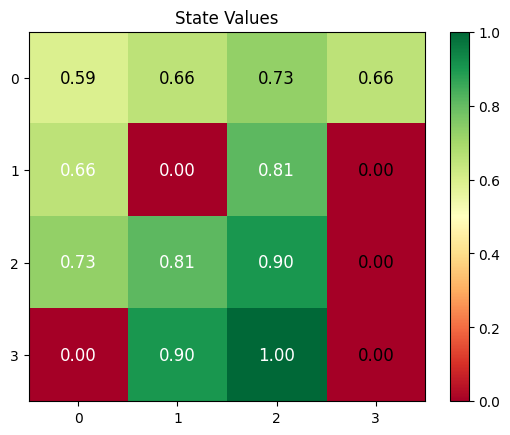

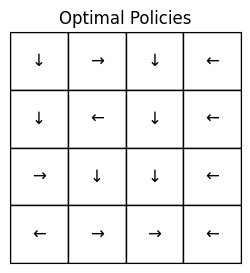

In [18]:
    discount_factor = 0.9
    step_to_converge_vi=np.zeros(5)
    time_to_converge_vi=np.zeros(5)
    for i in range(5):
        value_iteration = ValueIteration(env, discount_factor)
        start=time.time()
        value_iteration.value_estimation()
        end=time.time()
        time_to_converge_vi[i]=round(end-start,4)
        step_to_converge_vi[i]=value_iteration.get_step()
    visualize_state_values(value_iteration.get_state_values())
    visualize_optimal_policy(value_iteration)
    pygame.init()
    value_iteration.move_agent()
    pygame.quit()

<a name='1-3-2'></a>
#### Policy Iteration:

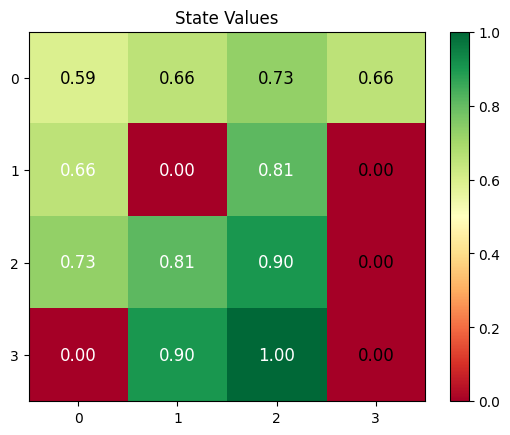

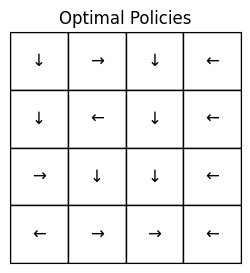

In [20]:
    
    discount_factor = 0.9
    step_to_converge_pi=np.zeros(5)
    time_to_converge_pi=np.zeros(5)
    for i in range(5):
        policy_iteration = PolicyIteration(env, discount_factor)
        start=time.time()
        policy_iteration.policy_estimation()
        end=time.time()
        time_to_converge_pi[i]=round(end-start,4)
        step_to_converge_pi[i]=policy_iteration.get_step()
    visualize_state_values(policy_iteration.get_state_values())
    visualize_optimal_policy(policy_iteration)
    pygame.init()
    policy_iteration.move_agent()
    pygame.quit()

<a name='1-4'></a>
### Question 6:

<a name='1-4-1'></a>
#### Value Iteration:

In [21]:
print(f"steps until converge in value iteration for five different episode(agent)={step_to_converge_vi}")
print(f"time elapsed until converge in value iteration for five different episode(agent)={time_to_converge_vi}")

steps until converge in value iteration for five different episode(agent)=[141. 141. 141. 141. 141.]
time elapsed until converge in value iteration for five different episode(agent)=[0.0361 0.0355 0.0402 0.0393 0.0382]


<a name='1-4-2'></a>
#### Policy Iteration:

In [22]:
print(f"steps until converge in policy iteration for five different episode(agent)={step_to_converge_pi}")
print(f"time elapsed until converge in policy iteration for five different episode(agent)={time_to_converge_pi}")

steps until converge in policy iteration for five different episode(agent)=[153. 154. 151. 154. 151.]
time elapsed until converge in policy iteration for five different episode(agent)=[0.022  0.0231 0.0186 0.0173 0.0221]


as you can see in Question 5 , state values and optimal policy for two algorithm are same;means that two algorithm can reach optimal policy.And also there is no such a big difference between two algorithm in number of steps to reach convergency when calculate state values.but the main difference between two algorithm is time until reach convergency and find optimal policy.
as you can see policy iteration works very better than value iteration in this feature,because in value iteration we loop over all actions and choose best one.so time complexity is $O(S^2A)$ but in policy iteration we just have one fixed policy and calculate state values just for this policy.so time complexity is $O(S^2)$.Policy iteration algorithm took almost $\dfrac{1}{A}$ time of value iteration.

<a name='2'></a>
## Part 2: Q-Learning Algorithm

In [23]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 119

<a name='2-1'></a>
### Question 7:

#### what is Q-Learning?
Q-Learning is a model-free reinforcement learning algorithm that is used to find the optimal action-selection policy for a given finite MDP.In this algorithm we don't know model of the enviroment (T and R).Agent when going in each step realize the reward of that step. To reach optimal policy at end we need to update out q_values after each action.because we don't know T so we after each sample we average last sample with q_value until now.So we update `Q(s,a)` based on the `sample` we see:
$$ sample = R(s,a,s')+\gamma max_{a'}Q(s',a')$$
$$ Q(s,a) = (1-\alpha)Q(s,a) + \alpha[sample]$$


<a name='2-1'></a>
### Question 8:

In [24]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.olr = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.seed = seed

    def choose_action(self, state):
        if(random.random()<self.epsilon):
            action = np.random.choice(self.env.action_space.n)
        else:
            action=self.get_optimal_policy(state)

        return action

    def update_q_table(self, state, action, nextState, reward):
        best_next_state_value=np.max(self.q_table[nextState])
        self.q_table[state][action] = ((1-self.learning_rate)*self.q_table[state][action])+(self.learning_rate*(reward+self.discount_factor*best_next_state_value))

    def decay_epsilon(self, episode):
        self.epsilon = self.epsilon*(1-episode/EPISODES)
        
    def decrease_learning_rate(self, episode):
        self.learning_rate = self.learning_rate*(1-episode/EPISODES)
        
    def take_action(self, action):
        next_state, reward, done, _,x = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_table[state])

    def get_q_values(self):
        return self.q_table

    def reset(self):
        self.learning_rate = self.olr
        return self.env.reset(seed=self.seed)

In [34]:
def agents_learning(env,decay_learning_rate):
    all_agents_rewards = np.zeros((REPS, EPISODES))
    all_agents_steps = np.zeros((REPS, EPISODES))
    for rep in range(REPS):
        agent = QLearningAgent(env,EPSILON,LEARNING_RATE,DISCOUNT,STUDENT_NUM) 
        for episode in range(EPISODES):
            initial_state_ = agent.reset()
            initial_state  = initial_state_[0]
            total_reward=0
            step=0
            while step<100 :
                bestAction=agent.choose_action(initial_state)
                next_state,reward,done = agent.take_action(bestAction)
                agent.update_q_table(initial_state, bestAction, next_state, reward)
                total_reward+=reward
                initial_state=next_state  
                if done:
                    break
                step+=1
            all_agents_steps[rep][episode]=step
            all_agents_rewards[rep][episode]=total_reward
            agent.decay_epsilon(episode)
            if decay_learning_rate:
                agent.decrease_learning_rate(episode)
    return all_agents_rewards , all_agents_steps , agent

In [35]:
def make_mean_array(agents_array):
    mean_array=np.zeros(EPISODES)
    for i in range(EPISODES):
        sum=0
        for j in range(REPS):
            sum+=agents_array[j][i]
        mean_array[i]=sum/REPS
    return mean_array

In [40]:
def plot_comparison(array1, array2,title="Comparison Plot"):
    episodes = range(1, len(array1) + 1)
    plt.figure(figsize=(7, 5))
    plt.plot(episodes, array1)
    plt.plot(episodes, array2)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend(["fixed learning rate","decreasing learning rate"])
    plt.grid(True)
    plt.xlim([0, 200])
    plt.show()

<a name='2-2'></a>
### Question 9:

In [41]:
env = gym.make('Taxi-v3',render_mode='rgb_array')
agents_rewards_1 , agents_steps_1 , agent_1 =agents_learning(env,False)
agents_rewards_2 , agents_steps_2 , agent_2 =agents_learning(env,True)

In [42]:
mean_rewards_1 = make_mean_array(agents_rewards_1)
mean_rewards_2 = make_mean_array(agents_rewards_2)
mean_steps_1 = make_mean_array(agents_steps_1)
mean_steps_2 = make_mean_array(agents_steps_2)

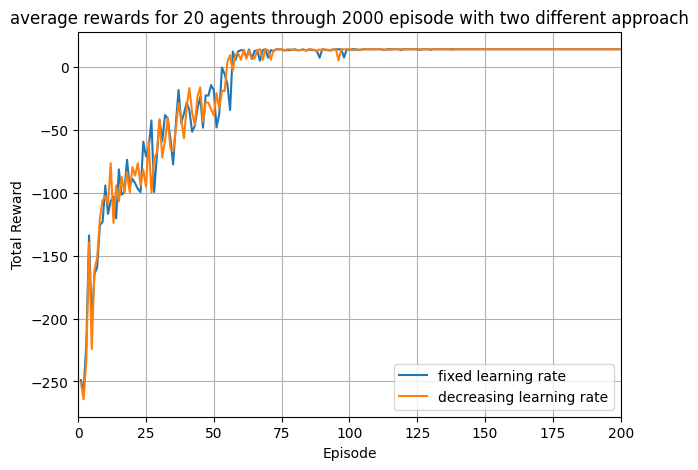

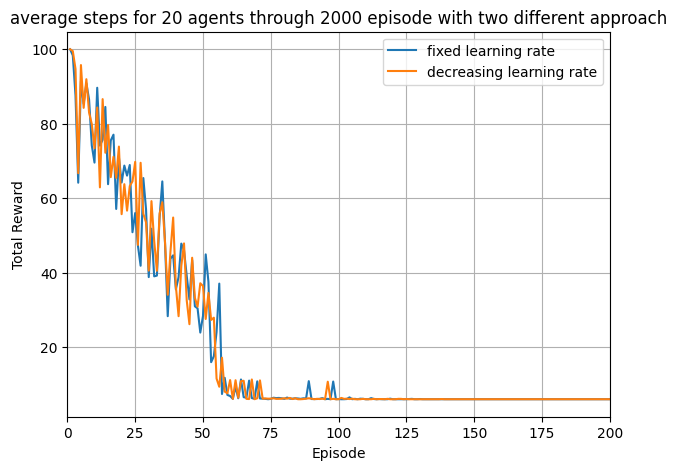

In [43]:
plot_comparison(mean_rewards_1,mean_rewards_2,"average rewards for 20 agents through 2000 episode with two different approach")
plot_comparison(mean_steps_1,mean_steps_2,"average steps for 20 agents through 2000 episode with two different approach")

Decreasing the learning rate in the Q-learning algorithm generally leads to slower convergence during training but can help us to ensure convergence.in our problem we reach convergence anyway so we cant't see big difference between two algorithm.but if we set our decrease_leaning_rate function in some way, it may result bad effects on our algorithm.  
The formula for decreasing epsilon:
$$\epsilon = initial\;\epsilon*(1-\frac{episode}{EPISODES})$$
in this formula $$\epsilon$$ is change between `0.1` to `0`.The bigger our episode is, the smaller the epsilon is, the closer it gets to zero.It helps us to at higher episodes our agent choose action usualy on optimal policy instead of choose action randomly. 

<a name='2-3'></a>
### Question 10:

In this section my render function in `human` render_mode not works so i forced to define visualize_moves function to show rgb_array in a graphical enviroment. 

In [44]:
def visualize_moves(rgb_array, frame_rate):
    frame_width,frame_height, _ = rgb_array.shape
    window = pygame.display.set_mode((frame_height, frame_width))
    frame = pygame.surfarray.make_surface(rgb_array)
    frame = pygame.transform.rotate(frame, -90)
    frame = pygame.transform.flip(frame, True, False)
    window.blit(frame, (0, 0))
    pygame.display.flip()
    time.sleep(1 / frame_rate)

In [45]:
pygame.init()
frame_rate=2
for episode in range(5):
    initial_state_=agent_1.reset()
    initial_state=initial_state_[0]
    done=False
    while not done:
        action = agent_1.choose_action(initial_state)
        next_state, reward, done = agent_1.take_action(action)
        initial_state=next_state
        rgb_array= agent_1.env.render()
        visualize_moves(rgb_array, frame_rate)
pygame.quit()

In [46]:
pygame.init()
frame_rate=2
for episode in range(5):
    initial_state_=agent_2.reset()
    initial_state=initial_state_[0]
    done=False
    while not done:
        action = agent_2.choose_action(initial_state)
        next_state, reward, done = agent_2.take_action(action)
        initial_state=next_state
        rgb_array= agent_2.env.render()
        visualize_moves(rgb_array, frame_rate)
pygame.quit()